In [37]:
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For model building and evaluation
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

###  Task 1 : Loading , exploring and cleaning

In [17]:
df=pd.read_csv("C:/Users/sabai/OneDrive/Desktop/Sem 6/DW/Labs/StudentsPerformance.csv")
df

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77


In [15]:
print(df.head())
print(df.info())
print(df.describe())

   gender race/ethnicity parental level of education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test preparation course  math score  reading score  writing score  
0                    none          72             72             74  
1               completed          69             90             88  
2                    none          90             95             93  
3                    none          47             57             44  
4                    none          76             78             75  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtyp

In [13]:
missing_counts = df.isnull().sum()
print("Missing values:\n", missing_counts)

Missing values:
 gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64


In [19]:
df['avg_score'] = df[['math score', 'reading score', 'writing score']].mean(axis=1)

# Create a binary target column: 1 if avg_score > 50, else 0
df['target'] = np.where(df['avg_score'] > 50, 1, 0)

In [35]:
# 5. Encode categorical variables
# Identify which columns are categorical
categorical_cols = []
for col in df.columns:
    # If col is object (string) and not the newly created target column
    if df[col].dtype == 'object' and col not in ['target']:
        categorical_cols.append(col)

# Encode categorical columns using LabelEncoder
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])


In [23]:
exclude_cols = ['target', 'avg_score']
feature_cols = [col for col in df.columns if col not in exclude_cols]

X = df[feature_cols].values
y = df['target'].values

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [29]:
k_values = [3, 5, 7, 9, 11]
cv_scores = {}

# Using a 5-fold split for cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

print("\nCross-validation results:")
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=kfold, scoring='accuracy')
    cv_scores[k] = scores.mean()
    print(f"K={k} | Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

# Best K based on cross-validation accuracy
best_k = max(cv_scores, key=cv_scores.get)
print("\nBest k from cross-validation:", best_k)


Cross-validation results:
K=3 | Accuracy: 0.9450 ± 0.0174
K=5 | Accuracy: 0.9563 ± 0.0148
K=7 | Accuracy: 0.9575 ± 0.0183
K=9 | Accuracy: 0.9463 ± 0.0161
K=11 | Accuracy: 0.9463 ± 0.0179

Best k from cross-validation: 7



Test Set Accuracy: 0.94

Classification Report:
              precision    recall  f1-score   support

    0 (<=50)       0.86      0.55      0.67        22
     1 (>50)       0.95      0.99      0.97       178

    accuracy                           0.94       200
   macro avg       0.90      0.77      0.82       200
weighted avg       0.94      0.94      0.93       200

Confusion Matrix:
[[ 12  10]
 [  2 176]]


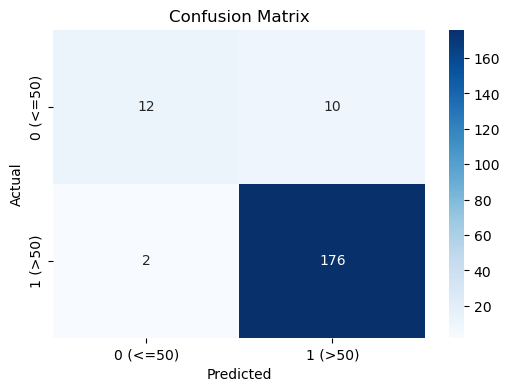


Final KNN Model: KNeighborsClassifier(n_neighbors=7)
Chosen K: 7


In [31]:
# 10. Train the final model using the best K

knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train_scaled, y_train)


# 11. Evaluate on the test set

y_pred = knn_final.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("\nTest Set Accuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['0 (<=50)', '1 (>50)']))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix for a clear visualization
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=['0 (<=50)', '1 (>50)'],
            yticklabels=['0 (<=50)', '1 (>50)'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

##############################################################################
# 12. Summarize
##############################################################################
print("\nFinal KNN Model:", knn_final)
print("Chosen K:", best_k)


Naive Bayes Cross-Validation Accuracy: 0.9550 ± 0.0228

Test Set Accuracy (Naive Bayes): 0.94

Classification Report (Naive Bayes):
              precision    recall  f1-score   support

    0 (<=50)       0.67      0.91      0.77        22
     1 (>50)       0.99      0.94      0.97       178

    accuracy                           0.94       200
   macro avg       0.83      0.93      0.87       200
weighted avg       0.95      0.94      0.94       200

Confusion Matrix (Naive Bayes):
[[ 20   2]
 [ 10 168]]


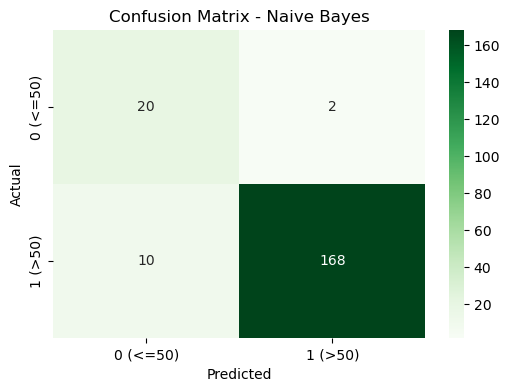


Final Naive Bayes Model: GaussianNB()


In [39]:
## Using naive bayes algorithm
nb = GaussianNB()

# Cross-validation on training set
nb_cv_scores = cross_val_score(nb, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("\nNaive Bayes Cross-Validation Accuracy: {:.4f} ± {:.4f}".format(
    nb_cv_scores.mean(), nb_cv_scores.std()))

##############################################################################
# 2. Train Final Naive Bayes Model on Entire Training Set
##############################################################################

nb.fit(X_train_scaled, y_train)

##############################################################################
# 3. Evaluate on the Test Set
##############################################################################

y_pred_nb = nb.predict(X_test_scaled)

# Accuracy
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("\nTest Set Accuracy (Naive Bayes):", accuracy_nb)

# Classification Report
print("\nClassification Report (Naive Bayes):")
print(classification_report(y_test, y_pred_nb, target_names=['0 (<=50)', '1 (>50)']))

# Confusion Matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)
print("Confusion Matrix (Naive Bayes):")
print(cm_nb)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_nb, annot=True, cmap='Greens', fmt='d',
            xticklabels=['0 (<=50)', '1 (>50)'],
            yticklabels=['0 (<=50)', '1 (>50)'])
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

##############################################################################
# 4. Summary
##############################################################################

print("\nFinal Naive Bayes Model:", nb)